In [1]:
# Basics
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import measure, color

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# For Stardist
import tensorflow as tf
print(tf.__version__)
layers = tf.keras.layers
from csbdeep.utils import normalize
from stardist.models import StarDist2D 
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

# prints a list of available models 
StarDist2D.from_pretrained() 

2.3.0
There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [3]:
# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


### Import data

In [4]:
path = 'data/DAPI/tif/'
agents = ["RPE1wt_CEP152+GTU88+PCNT_1",
          "RPE1wt_CEP63+CETN2+PCNT_1",
          "RPE1wt_CP110+GTU88+PCNT_2"]

id_ = ['_00'+ str(i) + '_00' + str(j) + '_max_C0.tif' for i in range(5) for j in range(5)]
paths = [path + agent + i for agent in agents for i in id_]

### Labeling

In [5]:
num = len(paths)

data = num*[None]
pts_col = num*[None]
proba_col = num*[None]
labels_col = num*[None]

current labeling:  0


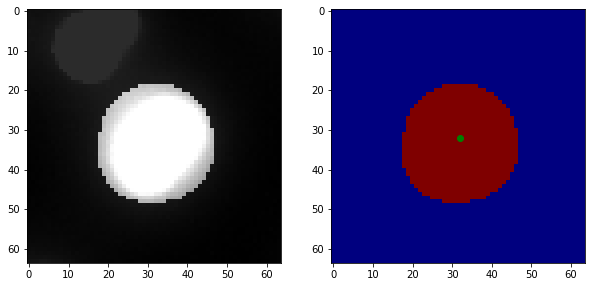

 1


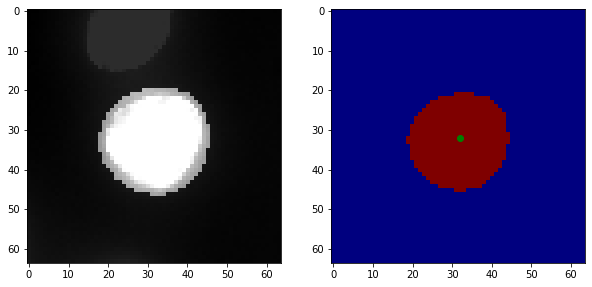

 1


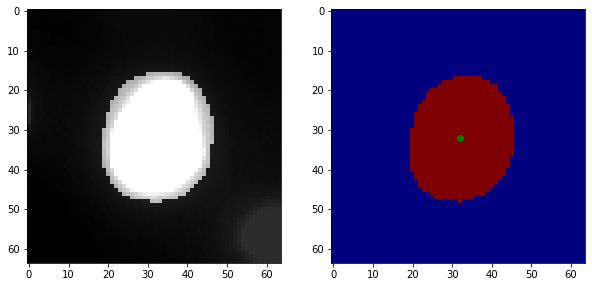

 1


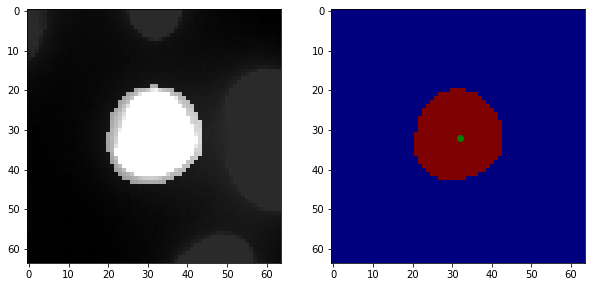

 1


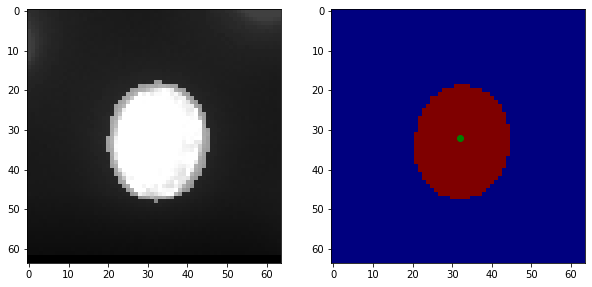

 1


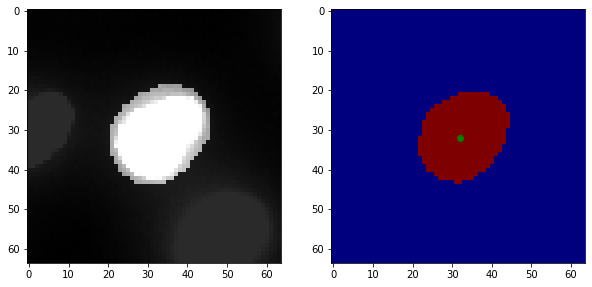

 1


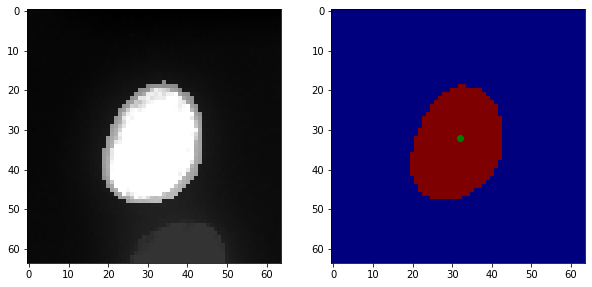

 1


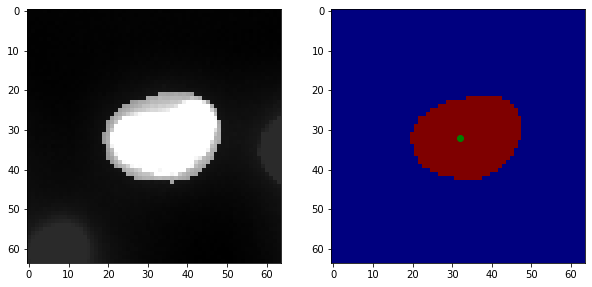

 1


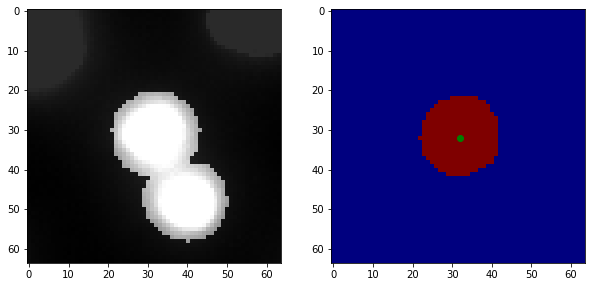

 1


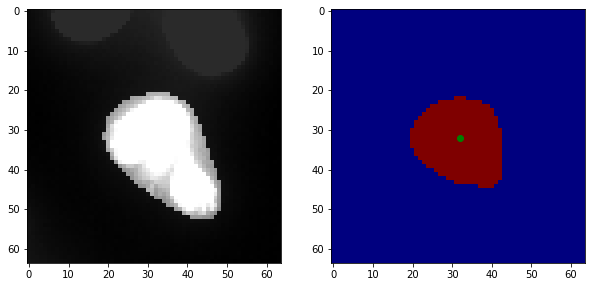

 2


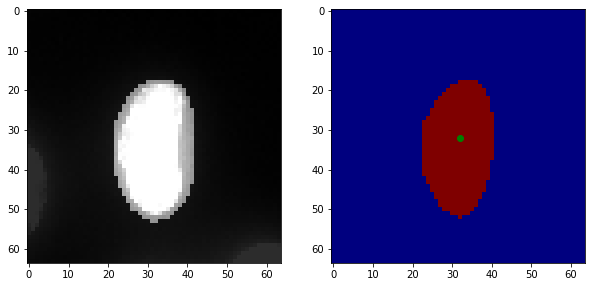

 1


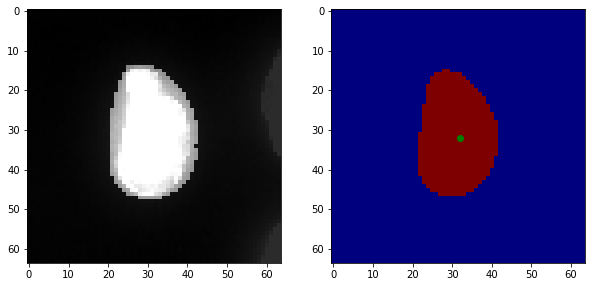

 1


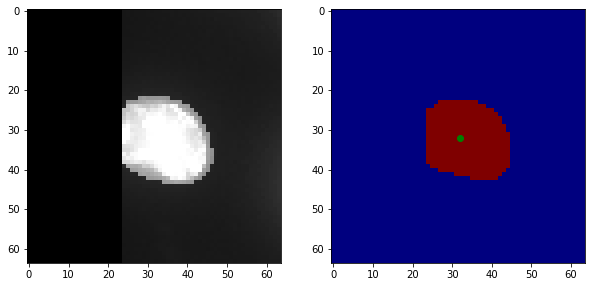

 0


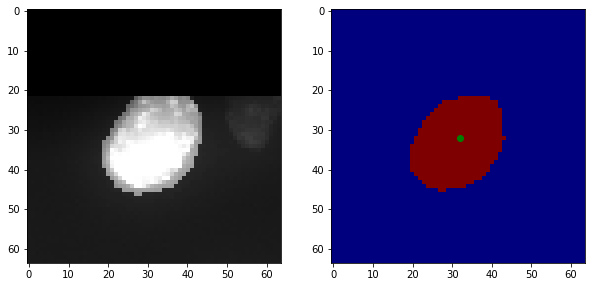

 0


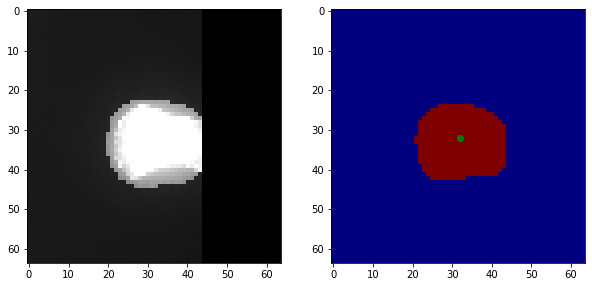

 0


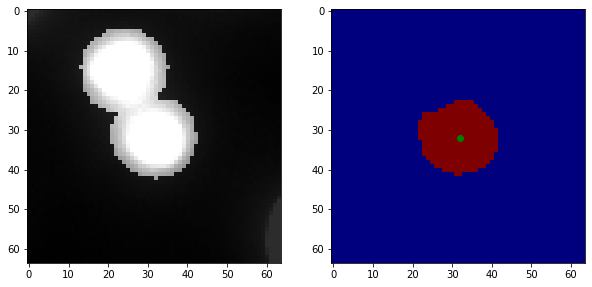

 1


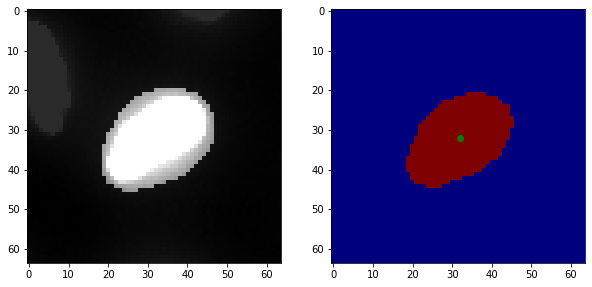

 1


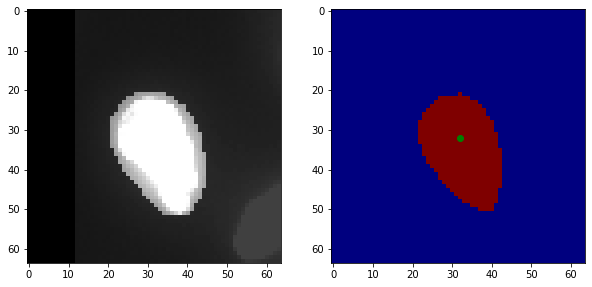

 1


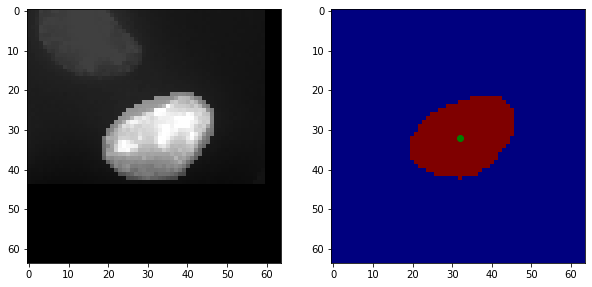

 0


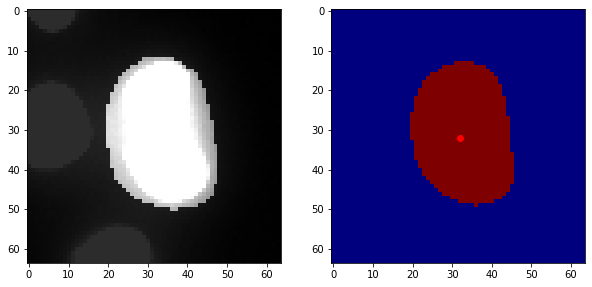

 1


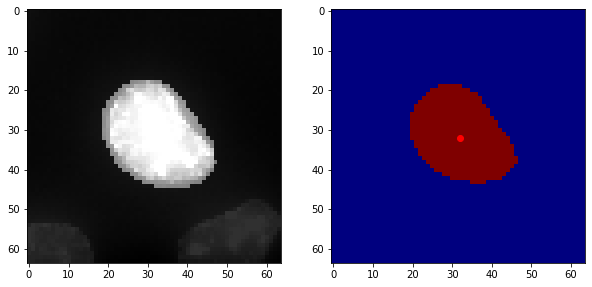

 1


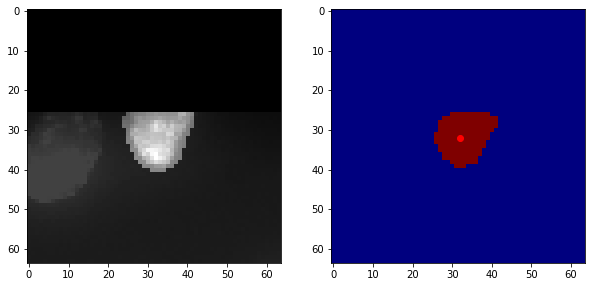

 0


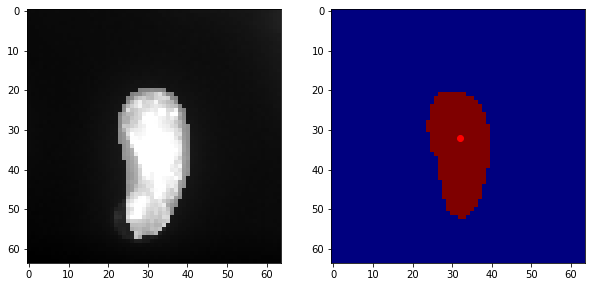

 2


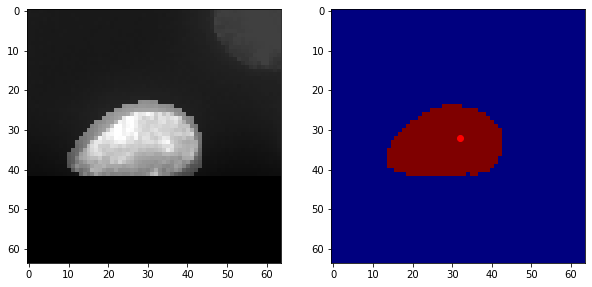

 0


In [6]:
# Define the serie to be labeled
serie = np.arange(0,1)

for idx in serie:
    print('current labeling: ', str(idx))
    # Load img
    raw = cv.imread(paths[idx], cv.IMREAD_UNCHANGED).astype(float)
    
    # Compute gradients in x and y directions using the Sobel mask
    grad_x = cv.Sobel(raw,ddepth=-1,dx=1,dy=0,ksize=31)
    grad_y = cv.Sobel(raw,ddepth=-1,dx=0,dy=1,ksize=31)
    grad_mag = np.sqrt(np.power(grad_x,2) + np.power(grad_y,2))
    grad_scaled = grad_mag/np.max(grad_mag)*np.max(raw)

    # Store pictures
    images = [grad_scaled, grad_scaled+raw, raw]

    # Scale them for Stardist use
    resized = [cv.resize(image, (256,256)) for image in images]
        
    # Run Stardist
    stack = []
    for img in resized:
        labels, infos = model.predict_instances(normalize(img))
        stack.append(labels)
        points = infos['points']
        prob = infos['prob']
        
    attention_mask = np.sum(np.array(stack),axis = 0)
    blobs = measure.label(attention_mask>1)
    
    # Add border
    add = 50

    input_ = cv.copyMakeBorder(resized[2], add, add, add, add, cv.BORDER_CONSTANT, value=[0, 0, 0])
    mask = cv.copyMakeBorder(blobs, add, add, add, add, cv.BORDER_CONSTANT, value=[0, 0, 0])
    output = cv.copyMakeBorder(labels, add, add, add, add, cv.BORDER_CONSTANT, value=[0, 0, 0])
    
    # define size of data
    size = 64
    e = int(size/2)
    
    cells = []
    for x,y,p in zip(points[:,0], points[:,1], prob[:]):
        
        # Compensate border 
        x += add
        y += add
        
        # Zoom on point location
        crop = mask[x-e:x+e,y-e:y+e]
        nuc = input_[x-e:x+e,y-e:y+e]
        out = output[x-e:x+e,y-e:y+e]
        
        # Get value at center of picture for attention mask and Stardist output
        nuc_mag = crop[32,32]
        out_mag = out[32,32]
        
        # Keep only area where value is the same
        nuc = nuc*((crop == nuc_mag)+0.25*(crop!=nuc_mag).astype(int))
        out = out*(out==out_mag)
    
        # Display for labeling
        plt.subplot(1,2,1)
        plt.imshow(nuc)

        plt.subplot(1,2,2)
        plt.imshow(out,cmap='jet')
        plt.scatter(e,e,color= ['green' if p>0.85 else 'red'])
        
        plt.show()
    
        # Ask target
        keep = int(input())
    
        # Store it
        cells.append([nuc,out,keep])
    
    # Store labeling
    data[idx] = cells
    
    # Store Stardist output
    pts_col[idx] = points
    proba_col[idx] = prob
    labels_col[idx] = labels
    

### Verify Labeling

In [10]:
# Redefine path, because we need png file
path1 = 'data/DAPI/png/'
agents = ["RPE1wt_CEP152+GTU88+PCNT_1",
          "RPE1wt_CEP63+CETN2+PCNT_1",
          "RPE1wt_CP110+GTU88+PCNT_2"]

id_1 = ['_00'+ str(i) + '_00' + str(j) + '_max_C0.png' for i in range(5) for j in range(5)]
paths1 = [path + agent + i for agent in agents for i in id_]

In [11]:
# Displaying function
def show(path_nbr):
    
    # target colors dictionnary
    colors = {0:'blue', 1:'green', 2:'yellow'}
    plt.figure(figsize=(20,20))
    
    # Check if labeling is done for the sample
    if data[path_nbr] != None:
        # get data
        plt.subplot(1,2,1)
        plt.imshow(cv.resize(plt.imread(paths1[path_nbr]), (256,256)))
        
        plt.subplot(1,2,2)
        plt.imshow(cv.resize(labels_col[path_nbr], (256,256)))
        
        plt.scatter(pts_col[path_nbr][:,1],pts_col[path_nbr][:,0],color=[colors[single[2]] for single in data[path_nbr]])
        plt.show()

    else: raise Exception('not Labeled')

0


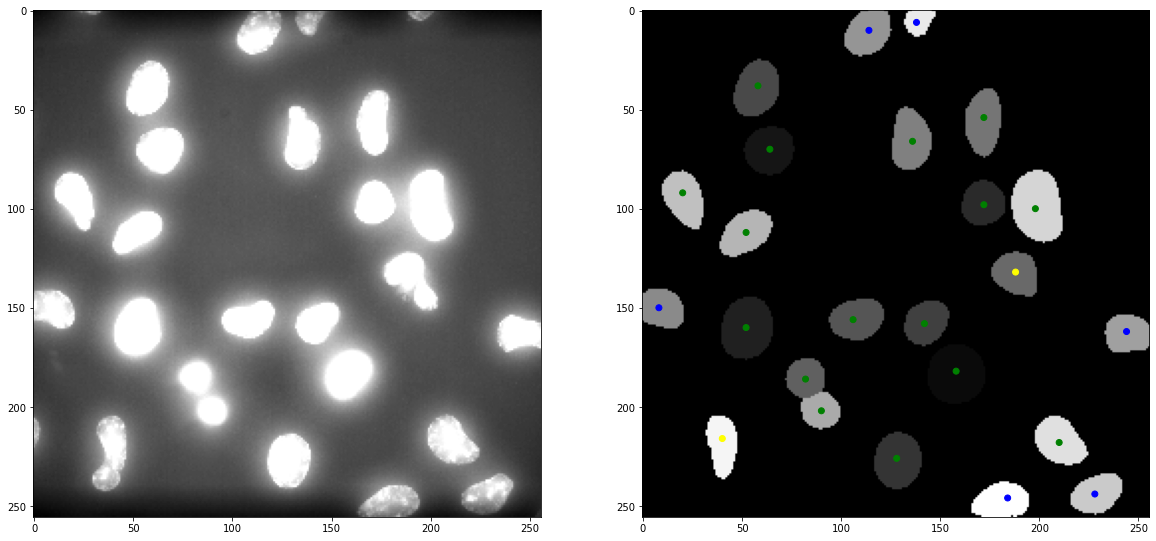

In [12]:
for i in range(1):
    print(i)
    show(i)

### Save Labeling

As `data` is a list of N elements [array of dtype float64, array of dtype int, int], we change it to the form [[arrays of dtype float64],[array of dtype int],[]]

In [14]:
# Create starage for nucleus
zoom_nuc = []

# Create starage for labels
zoom_lab = []

# Create starage for targets
tag = []

# Extract from data and store in corresponding storage
for i in range(len(data)):
    picture = data[i]
    for j in range(len(picture)):
        [zoom_nuc.append(picture[j][0])]
        [zoom_lab.append(picture[j][1])]
        [tag.append(picture[j][2])]

# Change to array
zoom_nuc = np.array(zoom_nuc)
zoom_lab = np.array(zoom_lab)
tag = np.array(tag)

TypeError: object of type 'NoneType' has no len()

In [143]:
# Export arrays
np.save('nuc_labeling/dum_nucleus', np.array(zoom_nuc))
np.save('nuc_labeling/dum_labels', np.array(zoom_lab))
np.save('nuc_labeling/dum_tags', np.array(tag))

test = np.load('nuc_labeling/dum_nucleus.npy')